In [1]:
import sys
from pathlib import Path
local_modules_path = str(Path('.').absolute().joinpath('mf6'))

sys.path.append(local_modules_path)
import numpy as np
from tempfile import TemporaryDirectory
from mf6.voronoiplus import TriangleGrid as Triangle
from shapely import Polygon
from mf6.voronoiplus import VoronoiGridPlus as Vor
from pathlib import Path
from mf6.simplemodel import SimpleModel
from mf6.headsplus import HeadsPlus as hp
import mf6.mfsimbase as mf
import shapely as shp
import pickle

vor_path = Path.home().joinpath('mf6','mf6_model' , 'vor.vor')

In [2]:
"""Example simple model"""
tri = Triangle(
    model_ws=Path.cwd(),
    angle=30
)
model_hull = tri.add_circle(radius=2000, center_coords=(50, 200), )
#facility = tri.add_circle(radius=10, center_coords=(50, 150), return_only=True)
facility = tri.add_rectangle(return_only=True)

outer_buffer = shp.Polygon(facility).buffer(0.5)
inner_buffer = shp.Polygon(facility).buffer(-0.5)
tri.add_polygon(outer_buffer)
tri.add_polygon(inner_buffer)

tri.add_regions(((10, 10), (300, 200)),
                maximum_areas=(4, 1000))
tri.build()
# get bottom elevs
strike = 30  # Strike given in degrees from north
dip = 5  # Dip given in degrees from horizontal
known_point = (50, 200, 0)  # Known point (x, y, elevation)
pixel_size = 10  # Pixel size
bottom_raster_path = Path.cwd().joinpath('bottom_raster.tif')
top_raster_path = Path.cwd().joinpath('top_raster.tif')
vor = Vor(tri)
print('getting rasters')
bottom_elevs = vor.get_raster_from_strike_dip(strike, dip, known_point, pixel_size, bottom_raster_path)
top_elevs = vor.get_raster_from_strike_dip(0, 0, (0,0,200), 10, top_raster_path)
print('got rasters')
vor = Vor(tri, rasters=[bottom_raster_path, top_raster_path])
nper = 31
facility_cells_idxs = vor.get_overlapping_grid_cells(shp.Polygon(facility)).to_list()

VoronoiGrid initialized.
Getting SciPy voronoi grid
Got SciPy voronoi grid
getting lats and lons
got lats and lons
getting rasters
getting elevations for raster
got raster from strike and dip
getting elevations for raster
got raster from strike and dip
got rasters
VoronoiGrid initialized.
Getting SciPy voronoi grid
Got SciPy voronoi grid
getting lats and lons
got lats and lons
ok
well done


In [3]:

rch_trans = [np.random.random() + 4 for per in range(nper)]
rch_dict = {}
for per in range(nper):
    cell_list = []
    for cell in range(vor.ncpl):
        if cell in facility_cells_idxs:
            cell_list.append([cell, rch_trans[per]])
        else:
            cell_list.append([cell, 0.0001])

    rch_dict[per] = cell_list
"""ADD WAY TO CALC CONDUCTANCE FROM K, L, and A"""
model = SimpleModel(
    vor,
    boundary_conductance=1000,
    nper=nper,
    rch_dict=rch_dict
)

"""save grid to file"""
vor_path = model.model_output_folder_path.joinpath('vor.vor')
with open(vor_path, "wb") as vor_file:
    pickle.dump(vor, vor_file, protocol=pickle.HIGHEST_PROTOCOL)

getting nja for disu
getting iac for disu
getting ja, cl12, and hwva for disu
getting cell areas


In [6]:
vor.plot_choropleth().show(renderer='browser')

In [5]:
vor.show_selected_cells(facility_cells_idxs).show(renderer='browser')

In [0]:
model.run_simulation()

In [3]:
hds = hp(hds_path=Path.home().joinpath('mf6','mf6_model' , 'mf6_model.hds'), vor=vor)

In [4]:
hds.plot_choropleth(stp_per_to_plot=(19,5), plot_mounding=True)

In [ ]:
### ### DASH ### ###
### DASH app to store selected cell ids ###

import dash
from dash import dcc
from dash import html, Input, Output
import dash_bootstrap_components as dbc

app = dash.Dash()
app.layout = html.Div(
    [
        dbc.Row(
            dbc.Col(
                [
                    dcc.Graph(
                        figure=vor.plot_choropleth(),
                        className="flex-grow-1",
                        style={"height": "95vh"},
                        id="fig",
                    )
                ],
                class_name="h-100 d-flex flex-column",
                style={"height": "95vh"},
            ),
            style={"height": "95vh"},
        ),
        dcc.Store(id="selected"),
    ],
    style={"height": "95vh"},
)


@app.callback(
    Output(component_id="selected", component_property="data"),
    Input(component_id="fig", component_property="selectedData"),
    prevent_initial_callbacks=True,
)
def on_select(selectedData):
    selected_cells = []
    for cell in selectedData["points"]:
        selected_cells.append(int(cell["location"]))
        print(selected_cells)
    return selected_cells


app.run(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

In [15]:
from budgetplus import BudgetPlus
import paths
bud = BudgetPlus(cbb_path=model.model_output_folder_path.joinpath('mf6_model.cbc'), vor=vor)

In [25]:
rch_bud = bud.get_rch_bud()
rch_bud = (rch_bud.reset_index(drop=True))

In [2]:
with open(vor_path, "rb") as vor_file_load:
    vor = pickle.load(vor_file_load)
vor.plot_choropleth().show()

In [4]:
from scipy.interpolate import griddata
import pandas as pd
import plotly.graph_objs as go
heads = hp(hds_path=Path.home().joinpath('mf6', 'mf6_model', 'mf6_model.hds'), vor=vor)
"""Get Voronoi Grid Centroid x,y-coords"""
centroids_xy = list(zip(vor.centroids_x, vor.centroids_y))

""""Get heads at Vornoi Grid Vertices"""
x_surface, y_surface = vor.generate_grid_coordinates(10)
xy = list(zip(x_surface, y_surface))

"""Interpolate heads at Voronoi Vertices"""
kstpkper = (19,15)  # stress period to get data from
gridded_heads = griddata(
    points=centroids_xy, values=heads.all_heads.loc[kstpkper,:]['elev'].to_list(), xi=xy, method="cubic"
)
gridded_model_botm = griddata(
    points=centroids_xy, values=vor.gdf_topbtm["bottom"], xi=xy, method="cubic"
)
xyz_heads = list(zip(x_surface, y_surface, gridded_heads, gridded_model_botm))

"""Make DataFrame of x,y,z coordinates, sort by y,
and drop any N/A values"""
df_xyz_gridded = pd.DataFrame(xyz_heads, columns=["x", "y", "head", "botm"])
df_xyz_gridded.sort_values(by=["y", "x"], inplace=True, ascending=False)
df_xyz_gridded.reset_index(drop=True, inplace=True)

In [5]:
df_xyz_gridded['mounding'] = df_xyz_gridded['head'] - df_xyz_gridded['botm']

In [9]:
"""Reshape x,y,z arrays for Surface plot"""
col_to_plot = 'head'
unqiue_y = list(set(df_xyz_gridded["y"].to_list()))
unqiue_x = list(set(df_xyz_gridded["x"].to_list()))
xcol = df_xyz_gridded["x"].to_list().count(unqiue_x[2])
yrow = df_xyz_gridded["y"].to_list().count(unqiue_y[2])
z_reshaped = df_xyz_gridded[col_to_plot].to_numpy().reshape(xcol, yrow)
mounding_reshaped = df_xyz_gridded['mounding'].to_numpy().reshape(xcol, yrow)
x_reshaped = df_xyz_gridded["x"].to_numpy().reshape(xcol, yrow)
y_reshaped = df_xyz_gridded["y"].to_numpy().reshape(xcol, yrow)
botm_reshaped = df_xyz_gridded["botm"].to_numpy().reshape(xcol, yrow)

z_min = df_xyz_gridded[col_to_plot].min()
z_max = df_xyz_gridded[col_to_plot].max()

surface_scene = go.layout.Scene(zaxis_range=[-500, 500])

fig_surf = go.Figure(
    go.Surface(
        z=z_reshaped,
        x=x_reshaped,
        y=y_reshaped,
        surfacecolor=mounding_reshaped,
        opacity=1,
        colorscale='earth',
        scene="scene",
        hovertemplate=
        contours={
            "z": {
                "show": True,
                "start": z_min,
                "end": z_max,
                "size": 2,
                "highlight": True,
                "width": 2,
            }
        },
    )
)
fig_surf.update_scenes(patch=surface_scene)

fig_surf.show(renderer="browser")

In [7]:
heads.plot_choropleth(stp_per_to_plot=(19,15), plot_mounding=True)

In [6]:
def add_rectangle(
        x_dist=100,
        y_dist=100,
        origin=(0, 0),
):
    x_min, y_min = origin[0], origin[1]
    x_max, y_max = x_min + x_dist, y_min + y_dist
    polygon_coords = ((x_min, y_min), (x_min, y_max),
                      (x_max, y_max), (x_max, y_min))
    polygon = shp.Polygon(polygon_coords)

    return polygon

In [7]:
rect = add_rectangle()

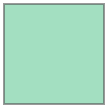

In [8]:
rect.